In [1]:
import numpy as np
import torch
from sbi import utils as utils
from sbi.inference.base import infer
import matplotlib.pyplot as plt
from data_read import read_obs, read_indiv_obs
from analysis_utils import violin_plots, welch_ttest,glassdelta_effect_size, mse, marked_dist_plot
import sklearn
import scipy.io
from scipy.stats import ttest_ind
import pickle
import copy
import pandas as pd
import seaborn as sns
from sbi import analysis as analysis
import pandas as pd
import configparser
from model import Model

train = True

In [2]:
all_labels = ['Aud Delay',
          'Somat Delay',
          'Log_10 Aud Noise Var',
          'Noise Ratio (Aud:Somat)',
          'Controller Gain']

def simulator_no_noise(parameter_set):
    config = configparser.ConfigParser()
    config.read('pitch_pert_configs.ini')
    override_params(config,parameter_set)
    model = Model(config)
    y_output,errors = model.run()
    pitch_output = y_output[:,0,0]
    pitch_output[pitch_output < 50] = 50
    pitch_baseline = np.mean(pitch_output[0:50])
    pitch_output_cents = 1200 * np.log2(pitch_output/pitch_baseline)
    return pitch_output_cents

def override_params(config,parameter_set):
    config['Observer']['aud_fdbk_delay'] = str(parameter_set[0].item())
    config['Observer']['somat_fdbk_delay'] = str(parameter_set[1].item())
    config['Vocal_Tract']['aud_noise_covariance'] = str(10**parameter_set[2].item())
    config['Vocal_Tract']['somat_noise_covariance'] = str(10**parameter_set[2].item() / parameter_set[3].item())
    config['Controller']['controller_gain'] = str(parameter_set[4].item())

def simulator(parameter_set):
    training_noise_scale = 7
    pitch_output_cents = simulator_no_noise(parameter_set)
    pitch_output_cents_wnoise = pitch_output_cents + ((np.random.rand(len(pitch_output_cents)) - 0.5) * training_noise_scale)
    return pitch_output_cents_wnoise

def compare(posterior, obs_list, n_samples,prior_min,prior_max,labels,fwer=0.05,fit_stde=False,name=None,xlabel=False):
    data_list=[]
    for observation in obs_list:
        np.random.seed(10)
        torch.manual_seed(10)
        samples = posterior.sample((n_samples,), x=observation.get('data'))
        log_probability = posterior.log_prob(samples, x=observation.get('data'))
        max_likelihood = samples[torch.argmax(log_probability)]
        print(max_likelihood)
        topk_likelihood = samples[torch.topk(log_probability,1000).indices]
        marked_dist_plot(samples, prior_min, prior_max, labels, max_likelihood=max_likelihood, actual_params=None, name=observation.get('name'))
        data = {'name': observation.get('name'),'color': observation.get('color'),'taxis':observation.get('taxis'),'samples':samples, 
                'max_likelihood': max_likelihood, 'topk_likelihood': topk_likelihood}
        data_list.append(data)
    sig_list = welch_ttest(data_list,fwer,len(labels))
    glass_delta_list = glassdelta_effect_size(data_list,len(labels),n_samples)
    plot_actual_data(obs_list)
    inferred_list = plot_actual_inferred_data(obs_list,data_list,name=name,xlabel=xlabel,ylabel=True,ylim=None)
    diff_list = np.ndarray((2,))
    diff_list[0] = mse(obs_list[0].get('data'),inferred_list[0,:])
    diff_list[1] = mse(obs_list[1].get('data'),inferred_list[1,:])
    print("MSE: " + str(diff_list))
    violin_plots(data_list,sig_list,glass_delta_list,prior_min,prior_max,labels,name)
    return data_list, diff_list
    
def plot_actual_data(obs_list,ax=None,xlabel=False,ylabel=False,ylim=[-5,45],legend=False,show_pert=False):
    if ax is None:
        fig, ax = plt.subplots()
    if show_pert:
        ax.axvspan(0,0.4,alpha=0.2,color='gray')
        ax.annotate('Perturbation',(0.01,40),fontsize=12,color='gray')
    for i, obs in enumerate(obs_list):
        ax.plot(obs.get('taxis'),obs.get('data'),label=obs.get('name'),linewidth=5,linestyle=':',color=obs.get('color'),alpha=0.5)
        ax.plot(obs.get('taxis'),obs.get('data')+obs.get('stde'),linewidth=2,linestyle=':',color=obs.get('color'))
        ax.plot(obs.get('taxis'),obs.get('data')-obs.get('stde'),linewidth=2,linestyle=':',color=obs.get('color'))
        #plt.fill_between(obs.get('taxis'),
        #             obs.get('data')+obs.get('stde'),
        #             obs.get('data')-obs.get('stde'),
        #             linewidth=5,color='#A3A3A3')
        if xlabel:
            ax.set_xlabel('Time (s)',fontsize=15)
            ax.tick_params(axis='x',which='major',labelsize=14)
        else: ax.set_xticks([])
        if ylabel:
            ax.set_ylabel('Pitch (cents)',fontsize=15)
            ax.tick_params(axis='y',which='major',labelsize=14)
        else: ax.set_yticks([])
        if ylim is not None:
            ax.set_ylim(ylim)
        if legend:
            ax.annotate(obs.get('name'), (0.7, 40-4*i), fontsize=15, color=obs.get('color'))
                     
def plot_actual_inferred_data(obs_list,data_list,ax=None,name=None,xlabel=False,ylabel=False,ylim=[-5,45],obs_to_plot=None,color=None,legend=True):
    ntrials = 1000
    inferred_list = np.ndarray((len(obs_list),len(obs_list[0].get('data'))))
    #plt.figure(figsize=(5,4))
    if ax is None:
        fig, ax = plt.subplots()
    if len(obs_list) < 5:
        plot_actual_data(obs_list,ax,xlabel,ylabel,ylim)
        for i, data in enumerate(data_list):
            #topk_likelihood = data.get('topk_likelihood')
            #ntrials = topk_likelihood.shape[0]
            if color is None: plot_color = data.get('color')
            else: plot_color = color
            taxis = obs_list[0].get('taxis')
            inferred_all = np.ndarray((ntrials,len(taxis)))
            for j in range(ntrials):
                #params = topk_likelihood[j,:]
                inferred_all[j,:] = simulator_no_noise(data.get('max_likelihood'))
                #inferred_all[j,:] = simulator_no_noise(params)
            inferred = np.median(inferred_all,axis=0)
            stde = np.std(inferred_all,axis=0) / np.sqrt(ntrials)
            inferred_list[i,:] = inferred
            if obs_to_plot is None or i in obs_to_plot:
                ax.plot(taxis,inferred,label=data.get('name')+' inferred',linewidth=5,color=plot_color)
                ax.plot(taxis,inferred-stde, linewidth=2,color=plot_color)
                ax.plot(taxis,inferred+stde, linewidth=2, color=plot_color)
    else: 
        for x in range(len(obs_list)):
            plot_actual_inferred_data([obs_list[x]],[data_list[x]],name=name,xlabel=xlabel)
    return inferred_list

def run_sbi(filename,nreps,prior_min_all,prior_max_all,all_labels,train=True,ablate=None):
    mse_sub = np.ndarray([2,nreps])
    labels = copy.deepcopy(all_labels)
    prior_min = copy.deepcopy(prior_min_all)
    prior_max = copy.deepcopy(prior_max_all)
    if ablate is not None:
        labels.pop(ablate)
        prior_min.pop(ablate)
        prior_max.pop(ablate)
    inferred_control_values_all = np.ndarray([len(labels),n_reps])
    for seed in range(nreps):
        if train:
            prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))
            np.random.seed(seed)
            torch.manual_seed(seed)
            posterior = infer(simulator,prior, method='SNPE', num_simulations=n_simulations)
            posterior_save = {'prior_min':prior_min,'prior_max':prior_max,'posterior':posterior,'seed':seed}
            with open('posterior/'+ filename + '_seed' + str(seed) + '.pkl', "wb") as handle:
                pickle.dump(posterior_save,handle)
        np.random.seed(seed)
        torch.manual_seed(seed)
        with open('posterior/'+ filename + '_seed' + str(seed) + '.pkl', 'rb') as handle:
            posterior_dict = pickle.load(handle)
        posterior_new = posterior_dict.get('posterior')
        prior_min = posterior_dict.get('prior_min')
        prior_max = posterior_dict.get('prior_max')
        data_list,mse_sub[:,seed] = compare(posterior_new,list(observation_dict.get('CA').values()),n_samples,prior_min,prior_max,labels,fit_stde=False,name='CA',xlabel=True)
        inferred_control_values_all[:,seed] = data_list[0].get('max_likelihood')
    return data_list,inferred_control_values_all,mse_sub    

In [3]:
observation_dict = {}
    
observation_dict['CA'] = {'Controls': read_obs('CA_Data/','CA','jh','control',"#E3787B"), 
                          'Patients': read_obs('CA_Data/','CA','jh','patient',"#FFD166")}

C:\Users\jgaines\Anaconda3\envs\pitch_model_env\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


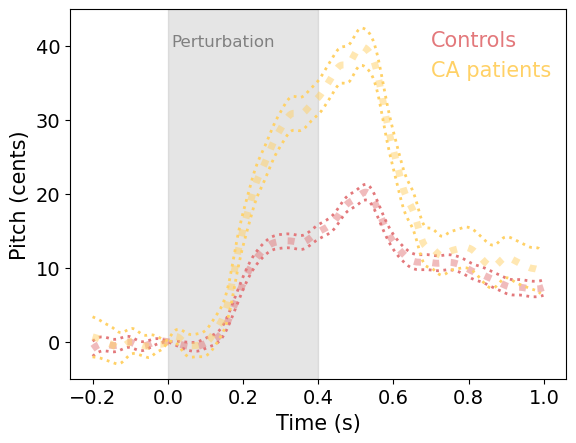

In [4]:
plot_actual_data(observation_dict.get('CA').values(),xlabel='Time (s)',ylabel='Pitch (cents)',legend=True,show_pert=True)

In [5]:
n_simulations = 100000
n_samples = 10000
n_reps = 10
mse_vals = np.ndarray([len(all_labels)+1,2,n_reps])

In [ ]:
prior_min_all = [70, 3, -12, 0.3333, 1.1]
prior_max_all = [150, 60, -1, 5, 8]
data_list,inferred_control_values_all, mse_vals[0,:,:] = run_sbi('all_params',n_reps,prior_min_all,prior_max_all,all_labels,train=train)
inferred_control_values = np.median(inferred_control_values_all,axis=1)
print(inferred_control_values)

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

In [17]:
#inferred_control_values = torch.tensor([113.6401,  24.5754,  -8.0638,   1.8892,   1.8559])

In [ ]:
def override_params(config,parameter_set):
    config['Observer']['aud_fdbk_delay'] = str(inferred_control_values[0].item())
    config['Observer']['somat_fdbk_delay'] = str(parameter_set[0].item())
    config['Vocal_Tract']['aud_noise_covariance'] = str(10**parameter_set[1].item())
    config['Vocal_Tract']['somat_noise_covariance'] = str(10**parameter_set[1].item() / parameter_set[2].item())
    config['Controller']['controller_gain'] = str(parameter_set[3].item())

data_list0,inferred_control_values_all0, mse_vals[1,:,:] = run_sbi('fix_aud_delay',n_reps,prior_min_all,prior_max_all,all_labels,train=train,ablate=0)

In [ ]:
def override_params(config,parameter_set):
    config['Observer']['aud_fdbk_delay'] = str(parameter_set[0].item())
    config['Observer']['somat_fdbk_delay'] = str(inferred_control_values[1].item())
    config['Vocal_Tract']['aud_noise_covariance'] = str(10**parameter_set[1].item())
    config['Vocal_Tract']['somat_noise_covariance'] = str(10**parameter_set[1].item() / parameter_set[2].item())
    config['Controller']['controller_gain'] = str(parameter_set[3].item())

data_list1,inferred_control_values_all1, mse_vals[2,:,:] = run_sbi('fix_som_delay',n_reps,prior_min_all,prior_max_all,all_labels,train=train,ablate=1)

In [ ]:
def override_params(config,parameter_set):
    config['Observer']['aud_fdbk_delay'] = str(parameter_set[0].item())
    config['Observer']['somat_fdbk_delay'] = str(parameter_set[1].item())
    config['Vocal_Tract']['aud_noise_covariance'] = str(10**inferred_control_values[2].item())
    config['Vocal_Tract']['somat_noise_covariance'] = str(10**inferred_control_values[2].item() / parameter_set[2].item())
    config['Controller']['controller_gain'] = str(parameter_set[3].item())

data_list2,inferred_control_values_all2, mse_vals[3,:,:] = run_sbi('fix_aud_noise',n_reps,prior_min_all,prior_max_all,all_labels,train=train,ablate=2)

In [ ]:
def override_params(config,parameter_set):
    config['Observer']['aud_fdbk_delay'] = str(parameter_set[0].item())
    config['Observer']['somat_fdbk_delay'] = str(parameter_set[1].item())
    config['Vocal_Tract']['aud_noise_covariance'] = str(10**parameter_set[2].item())
    config['Vocal_Tract']['somat_noise_covariance'] = str(10**parameter_set[2].item() / inferred_control_values[3].item())
    config['Controller']['controller_gain'] = str(parameter_set[3].item())

data_list3,inferred_control_values_all3, mse_vals[4,:,:] = run_sbi('fix_noise_ratio',n_reps,prior_min_all,prior_max_all,all_labels,train=train,ablate=3)

In [ ]:
def override_params(config,parameter_set):
    config['Observer']['aud_fdbk_delay'] = str(parameter_set[0].item())
    config['Observer']['somat_fdbk_delay'] = str(parameter_set[1].item())
    config['Vocal_Tract']['aud_noise_covariance'] = str(10**parameter_set[2].item())
    config['Vocal_Tract']['somat_noise_covariance'] = str(10**parameter_set[2].item() / parameter_set[3].item())
    config['Controller']['controller_gain'] = str(inferred_control_values[4].item())

data_list4,inferred_control_values_all4, mse_vals[5,:,:] = run_sbi('fix_ctrl_gain',n_reps,prior_min_all,prior_max_all,all_labels,train=train,ablate=4)

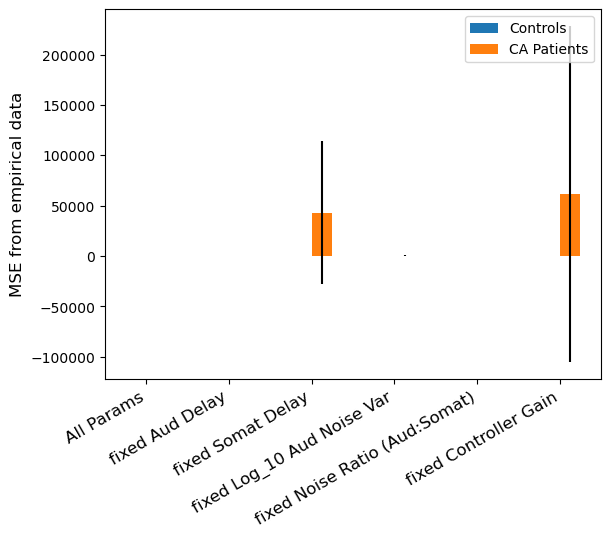

,Controls,CA Patients,Labels
0,4.594804,25.871309,All Params
1,206.578299,127.017774,fixed Aud Delay
2,2.931822,70672.842264,fixed Somat Delay
3,2.660635,402.450755,fixed Log_10 Aud Noise Var
4,1.343946,14.736760,fixed Noise Ratio (Aud:Somat)
5,1.828923,166747.216125,fixed Controller Gain


In [49]:
bar_data = np.mean(mse_vals,axis=2)
bar_df = pd.DataFrame(bar_data,columns=['Controls','CA Patients'])
se_data = np.std(mse_vals,axis=2)
se_df = pd.DataFrame(se_data,columns = ['Controls','CA Patients'])
labels = copy.deepcopy(all_labels)
labels = ['fixed ' + label for label in labels]
labels.insert(0,'All Params')
bar_df['Labels'] = labels
se_df['Labels'] = labels
bar_df.plot(kind='bar',yerr=se_df,rot=0)
plt.ylabel('MSE from empirical data',fontsize=12)
plt.xticks(ticks=range(len(labels)),labels=labels,fontsize=12,rotation=30,ha='right')
plt.show()
se_df